# How to use the graph API

This guide demonstrates the basics of LangGraph's Graph API. It walks through [state](#define-and-update-state), as well as composing common graph structures such as [sequences](#create-a-sequence-of-steps), [branches](#create-branches), and [loops](#create-and-control-loops). It also covers LangGraph's control features, including the [Send API](#map-reduce-and-the-send-api) for map-reduce workflows and the [Command API](#combine-control-flow-and-state-updates-with-command) for combining state updates with "hops" across nodes.

## Setup

Install `langgraph`:

In [ ]:
%pip install -qU langgraph

<div class="admonition tip">
     <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for better debugging</p>
     <p style="padding-top: 5px;">
         Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM aps built with LangGraph — read more about how to get started in the <a href="https://docs.smith.langchain.com">docs</a>. 
     </p>
 </div>

## Define and update state

Here we show how to define and update [state](../../concepts/low_level/#state) in LangGraph. We will demonstrate:

1. How to use state to define a graph's [schema](../../concepts/low_level/#schema)
2. How to use [reducers](../../concepts/low_level/#reducers) to control how state updates are processed.

### Define state

[State](../../concepts/low_level/#state) in LangGraph can be a `TypedDict`, `Pydantic` model, or dataclass. Below we will use `TypedDict`. See [this section](#use-pydantic-models-for-graph-state) for detail on using Pydantic.

By default, graphs will have the same input and output schema, and the state determines that schema. See [this section](#define-input-and-output-schemas) for how to define distinct input and output schemas.

Let's consider a simple example using [messages](../../concepts/low_level/#messagesstate). This represents a versatile formulation of state for many LLM applications. See our [concepts page](../../concepts/low_level/#working-with-messages-in-graph-state) for more detail.

In [1]:
from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict


class State(TypedDict):
    messages: list[AnyMessage]
    extra_field: int

This state tracks a list of [message](https://python.langchain.com/docs/concepts/messages/) objects, as well as an extra integer field.

### Update state

Let's build an example graph with a single node. Our [node](../../concepts/low_level/#nodes) is just a Python function that reads our graph's state and makes updates to it. The first argument to this function will always be the state:

In [2]:
from langchain_core.messages import AIMessage


def node(state: State):
    messages = state["messages"]
    new_message = AIMessage("Hello!")

    return {"messages": messages + [new_message], "extra_field": 10}

This node simply appends a message to our message list, and populates an extra field.

!!! important

    Nodes should return updates to the state directly, instead of mutating the state.

Let's next define a simple graph containing this node. We use [StateGraph](../../concepts/low_level/#stategraph) to define a graph that operates on this state. We then use [add_node](../../concepts/low_level/#nodes) populate our graph.

In [3]:
from langgraph.graph import StateGraph

builder = StateGraph(State)
builder.add_node(node)
builder.set_entry_point("node")
graph = builder.compile()

LangGraph provides built-in utilities for visualizing your graph. Let's inspect our graph. See [this section](#visualize-your-graph) for detail on visualization.

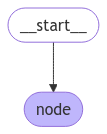

In [4]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In this case, our graph just executes a single node. Let's proceed with a simple invocation:

In [5]:
from langchain_core.messages import HumanMessage

result = graph.invoke({"messages": [HumanMessage("Hi")]})
result

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Hello!', additional_kwargs={}, response_metadata={})],
 'extra_field': 10}

Note that:

- We kicked off invocation by updating a single key of the state.
- We receive the entire state in the invocation result.

For convenience, we frequently inspect the content of [message objects](https://python.langchain.com/docs/concepts/messages/) via pretty-print:

In [6]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hello!


### Process state updates with reducers

Each key in the state can have its own independent [reducer](../../concepts/low_level/#reducers) function, which controls how updates from nodes are applied. If no reducer function is explicitly specified then it is assumed that all updates to the key should override it.

For `TypedDict` state schemas, we can define reducers by annotating the corresponding field of the state with a reducer function.

In the earlier example, our node updated the `"messages"` key in the state by appending a message to it. Below, we add a reducer to this key, such that updates are automatically appended:

In [7]:
from typing_extensions import Annotated


def add(left, right):
    """Can also import `add` from the `operator` built-in."""
    return left + right


class State(TypedDict):
    # highlight-next-line
    messages: Annotated[list[AnyMessage], add]
    extra_field: int

Now our node can be simplified:

In [8]:
def node(state: State):
    new_message = AIMessage("Hello!")
    # highlight-next-line
    return {"messages": [new_message], "extra_field": 10}

In [10]:
from langgraph.graph import START


graph = StateGraph(State).add_node(node).add_edge(START, "node").compile()

result = graph.invoke({"messages": [HumanMessage("Hi")]})

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hello!


#### MessagesState

In practice, there are additional considerations for updating lists of messages:

- We may wish to update an existing message in the state.
- We may want to accept short-hands for [message formats](../../concepts/low_level/#using-messages-in-your-graph), such as [OpenAI format](https://python.langchain.com/docs/concepts/messages/#openai-format).

LangGraph includes a built-in reducer `add_messages` that handles these considerations:

In [11]:
from langgraph.graph.message import add_messages


class State(TypedDict):
    # highlight-next-line
    messages: Annotated[list[AnyMessage], add_messages]
    extra_field: int


def node(state: State):
    new_message = AIMessage("Hello!")
    return {"messages": [new_message], "extra_field": 10}


graph = StateGraph(State).add_node(node).set_entry_point("node").compile()

In [12]:
# highlight-next-line
input_message = {"role": "user", "content": "Hi"}

result = graph.invoke({"messages": [input_message]})

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hello!


This is a versatile representation of state for applications involving [chat models](https://python.langchain.com/docs/concepts/chat_models/). LangGraph includes a pre-built `MessagesState` for convenience, so that we can have:

In [13]:
from langgraph.graph import MessagesState


class State(MessagesState):
    extra_field: int

### Define input and output schemas

By default, `StateGraph` operates with a single schema, and all nodes are expected to communicate using that schema. However, it's also possible to define distinct input and output schemas for a graph.

When distinct schemas are specified, an internal schema will still be used for communication between nodes. The input schema ensures that the provided input matches the expected structure, while the output schema filters the internal data to return only the relevant information according to the defined output schema.

Below, we'll see how to define distinct input and output schema.

In [ ]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict


# Define the schema for the input
class InputState(TypedDict):
    question: str


# Define the schema for the output
class OutputState(TypedDict):
    answer: str


# Define the overall schema, combining both input and output
class OverallState(InputState, OutputState):
    pass


# Define the node that processes the input and generates an answer
def answer_node(state: InputState):
    # Example answer and an extra key
    return {"answer": "bye", "question": state["question"]}


# Build the graph with input and output schemas specified
builder = StateGraph(OverallState, input_schema=InputState, output_schema=OutputState)
builder.add_node(answer_node)  # Add the answer node
builder.add_edge(START, "answer_node")  # Define the starting edge
builder.add_edge("answer_node", END)  # Define the ending edge
graph = builder.compile()  # Compile the graph

# Invoke the graph with an input and print the result
print(graph.invoke({"question": "hi"}))

{'answer': 'bye'}


Notice that the output of invoke only includes the output schema.

### Pass private state between nodes

In some cases, you may want nodes to exchange information that is crucial for intermediate logic but doesn’t need to be part of the main schema of the graph. This private data is not relevant to the overall input/output of the graph and should only be shared between certain nodes.

Below, we'll create an example sequential graph consisting of three nodes (node_1, node_2 and node_3), where private data is passed between the first two steps (node_1 and node_2), while the third step (node_3) only has access to the public overall state.

In [1]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict


# The overall state of the graph (this is the public state shared across nodes)
class OverallState(TypedDict):
    a: str


# Output from node_1 contains private data that is not part of the overall state
class Node1Output(TypedDict):
    private_data: str


# The private data is only shared between node_1 and node_2
def node_1(state: OverallState) -> Node1Output:
    output = {"private_data": "set by node_1"}
    print(f"Entered node `node_1`:\n\tInput: {state}.\n\tReturned: {output}")
    return output


# Node 2 input only requests the private data available after node_1
class Node2Input(TypedDict):
    private_data: str


def node_2(state: Node2Input) -> OverallState:
    output = {"a": "set by node_2"}
    print(f"Entered node `node_2`:\n\tInput: {state}.\n\tReturned: {output}")
    return output


# Node 3 only has access to the overall state (no access to private data from node_1)
def node_3(state: OverallState) -> OverallState:
    output = {"a": "set by node_3"}
    print(f"Entered node `node_3`:\n\tInput: {state}.\n\tReturned: {output}")
    return output


# Connect nodes in a sequence
# node_2 accepts private data from node_1, whereas
# node_3 does not see the private data.
builder = StateGraph(OverallState).add_sequence([node_1, node_2, node_3])
builder.add_edge(START, "node_1")
graph = builder.compile()

# Invoke the graph with the initial state
response = graph.invoke(
    {
        "a": "set at start",
    }
)

print()
print(f"Output of graph invocation: {response}")

Entered node `node_1`:
	Input: {'a': 'set at start'}.
	Returned: {'private_data': 'set by node_1'}
Entered node `node_2`:
	Input: {'private_data': 'set by node_1'}.
	Returned: {'a': 'set by node_2'}
Entered node `node_3`:
	Input: {'a': 'set by node_2'}.
	Returned: {'a': 'set by node_3'}

Output of graph invocation: {'a': 'set by node_3'}


### Use Pydantic models for graph state

A [StateGraph](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.StateGraph) accepts a `state_schema` argument on initialization that specifies the "shape" of the state that the nodes in the graph can access and update.

In our examples, we typically use a python-native `TypedDict` for `state_schema`, but `state_schema` can be any [type](https://docs.python.org/3/library/stdtypes.html#type-objects).

Here, we'll see how a [Pydantic BaseModel](https://docs.pydantic.dev/latest/api/base_model/). can be used for `state_schema` to add run time validation on **inputs**.


<div class="admonition note">
    <p class="admonition-title">Known Limitations</p>
    <p>
        <ul>      
            <li>
                Currently, the output of the graph will <b>NOT</b> be an instance of a pydantic model.
            </li>
            <li>
                Run-time validation only occurs on inputs into nodes, not on the outputs.
            </li>
            <li>
                The validation error trace from pydantic does not show which node the error arises in.
            </li>
        </ul>
    </p>
</div>

In [4]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

from pydantic import BaseModel


# The overall state of the graph (this is the public state shared across nodes)
class OverallState(BaseModel):
    a: str


def node(state: OverallState):
    return {"a": "goodbye"}


# Build the state graph
builder = StateGraph(OverallState)
builder.add_node(node)  # node_1 is the first node
builder.add_edge(START, "node")  # Start the graph with node_1
builder.add_edge("node", END)  # End the graph after node_1
graph = builder.compile()

# Test the graph with a valid input
graph.invoke({"a": "hello"})

{'a': 'goodbye'}

Invoke the graph with an **invalid** input

In [5]:
try:
    graph.invoke({"a": 123})  # Should be a string
except Exception as e:
    print("An exception was raised because `a` is an integer rather than a string.")
    print(e)

An exception was raised because `a` is an integer rather than a string.
1 validation error for OverallState
a
  Input should be a valid string [type=string_type, input_value=123, input_type=int]
    For further information visit https://errors.pydantic.dev/2.9/v/string_type


See below for additional features of Pydantic model state:

<details class="example">
<summary>Serialization Behavior</summary>

When using Pydantic models as state schemas, it's important to understand how serialization works, especially when:
<ul>
<li>Passing Pydantic objects as inputs</li>
<li>Receiving outputs from the graph</li>
<li>Working with nested Pydantic models</li>
</ul>
Let's see these behaviors in action.
<br>

In [ ]:
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel


class NestedModel(BaseModel):
    value: str


class ComplexState(BaseModel):
    text: str
    count: int
    nested: NestedModel


def process_node(state: ComplexState):
    # Node receives a validated Pydantic object
    print(f"Input state type: {type(state)}")
    print(f"Nested type: {type(state.nested)}")

    # Return a dictionary update
    return {"text": state.text + " processed", "count": state.count + 1}


# Build the graph
builder = StateGraph(ComplexState)
builder.add_node("process", process_node)
builder.add_edge(START, "process")
builder.add_edge("process", END)
graph = builder.compile()

# Create a Pydantic instance for input
input_state = ComplexState(text="hello", count=0, nested=NestedModel(value="test"))
print(f"Input object type: {type(input_state)}")

# Invoke graph with a Pydantic instance
result = graph.invoke(input_state)
print(f"Output type: {type(result)}")
print(f"Output content: {result}")

# Convert back to Pydantic model if needed
output_model = ComplexState(**result)
print(f"Converted back to Pydantic: {type(output_model)}")

</details>

<details class="example"><summary>Runtime Type Coercion</summary>

Pydantic performs runtime type coercion for certain data types. This can be helpful but also lead to unexpected behavior if you're not aware of it.
<br>

In [ ]:
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel


class CoercionExample(BaseModel):
    # Pydantic will coerce string numbers to integers
    number: int
    # Pydantic will parse string booleans to bool
    flag: bool


def inspect_node(state: CoercionExample):
    print(f"number: {state.number} (type: {type(state.number)})")
    print(f"flag: {state.flag} (type: {type(state.flag)})")
    return {}


builder = StateGraph(CoercionExample)
builder.add_node("inspect", inspect_node)
builder.add_edge(START, "inspect")
builder.add_edge("inspect", END)
graph = builder.compile()

# Demonstrate coercion with string inputs that will be converted
result = graph.invoke({"number": "42", "flag": "true"})

# This would fail with a validation error
try:
    graph.invoke({"number": "not-a-number", "flag": "true"})
except Exception as e:
    print(f"\nExpected validation error: {e}")

</details>

<details class="example"><summary>Working with Message Models</summary>

When working with LangChain message types in your state schema, there are important considerations for serialization. You should use <code>AnyMessage</code> (rather than <code>BaseMessage</code>) for proper serialization/deserialization when using message objects over the wire.
<br>

In [ ]:
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel
from langchain_core.messages import HumanMessage, AIMessage, AnyMessage
from typing import List


class ChatState(BaseModel):
    messages: List[AnyMessage]
    context: str


def add_message(state: ChatState):
    return {"messages": state.messages + [AIMessage(content="Hello there!")]}


builder = StateGraph(ChatState)
builder.add_node("add_message", add_message)
builder.add_edge(START, "add_message")
builder.add_edge("add_message", END)
graph = builder.compile()

# Create input with a message
initial_state = ChatState(
    messages=[HumanMessage(content="Hi")], context="Customer support chat"
)

result = graph.invoke(initial_state)
print(f"Output: {result}")

# Convert back to Pydantic model to see message types
output_model = ChatState(**result)
for i, msg in enumerate(output_model.messages):
    print(f"Message {i}: {type(msg).__name__} - {msg.content}")

</details>

## Add runtime configuration

Sometimes you want to be able to configure your graph when calling it. For example, you might want to be able to specify what LLM or system prompt to use at runtime, *without polluting the graph state with these parameters*.

To add runtime configuration:

1. Specify a schema for your configuration
2. Add the configuration to the function signature for nodes or conditional edges
3. Pass the configuration into the graph.

See below for a simple example:

In [13]:
from langchain_core.runnables import RunnableConfig
from langgraph.graph import END, StateGraph, START
from typing_extensions import TypedDict


# 1. Specify config schema
class ConfigSchema(TypedDict):
    my_runtime_value: str


# 2. Define a graph that accesses the config in a node
class State(TypedDict):
    my_state_value: str


# highlight-next-line
def node(state: State, config: RunnableConfig):
    # highlight-next-line
    if config["configurable"]["my_runtime_value"] == "a":
        return {"my_state_value": 1}
        # highlight-next-line
    elif config["configurable"]["my_runtime_value"] == "b":
        return {"my_state_value": 2}
    else:
        raise ValueError("Unknown values.")


# highlight-next-line
builder = StateGraph(State, config_schema=ConfigSchema)
builder.add_node(node)
builder.add_edge(START, "node")
builder.add_edge("node", END)

graph = builder.compile()

# 3. Pass in configuration at runtime:
# highlight-next-line
print(graph.invoke({}, {"configurable": {"my_runtime_value": "a"}}))
# highlight-next-line
print(graph.invoke({}, {"configurable": {"my_runtime_value": "b"}}))

{'my_state_value': 1}
{'my_state_value': 2}


<details class="example"><summary>Extended example: specifying LLM at runtime</summary>

Below we demonstrate a practical example in which we configure what LLM to use at runtime. We will use both OpenAI and Anthropic models.
<br>

In [ ]:
%%capture --no-stderr
%pip install -U langgraph "langchain[anthropic,openai]"

In [1]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")
_set_env("OPENAI_API_KEY")

Build the graph:

In [1]:
from langchain.chat_models import init_chat_model
from langchain_core.runnables import RunnableConfig
from langgraph.graph import MessagesState
from langgraph.graph import END, StateGraph, START
from typing_extensions import TypedDict


class ConfigSchema(TypedDict):
    model: str


MODELS = {
    "anthropic": init_chat_model("anthropic:claude-3-5-haiku-latest"),
    "openai": init_chat_model("openai:gpt-4.1-mini"),
}


def call_model(state: MessagesState, config: RunnableConfig):
    model = config["configurable"].get("model", "anthropic")
    model = MODELS[model]
    response = model.invoke(state["messages"])
    return {"messages": [response]}


builder = StateGraph(MessagesState, config_schema=ConfigSchema)
builder.add_node("model", call_model)
builder.add_edge(START, "model")
builder.add_edge("model", END)

graph = builder.compile()

# Usage
input_message = {"role": "user", "content": "hi"}
# With no configuration, uses default (Anthropic)
response_1 = graph.invoke({"messages": [input_message]})["messages"][-1]
# Or, can set OpenAI
config = {"configurable": {"model": "openai"}}
response_2 = graph.invoke({"messages": [input_message]}, config=config)["messages"][-1]

print(response_1.response_metadata["model_name"])
print(response_2.response_metadata["model_name"])

claude-3-5-haiku-20241022
gpt-4.1-mini-2025-04-14


</details>

<details class="example"><summary>Extended example: specifying model and system message at runtime</summary>

Below we demonstrate a practical example in which we configure two parameters: the LLM and system message to use at runtime.
<br>

In [ ]:
%%capture --no-stderr
%pip install -U langgraph "langchain[anthropic,openai]"

In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")
_set_env("OPENAI_API_KEY")

In [1]:
from typing import Optional

from langchain.chat_models import init_chat_model
from langchain_core.messages import SystemMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import END, MessagesState, StateGraph, START
from typing_extensions import TypedDict


class ConfigSchema(TypedDict):
    model: Optional[str]
    system_message: Optional[str]


MODELS = {
    "anthropic": init_chat_model("anthropic:claude-3-5-haiku-latest"),
    "openai": init_chat_model("openai:gpt-4.1-mini"),
}


def call_model(state: MessagesState, config: RunnableConfig):
    model = config["configurable"].get("model", "anthropic")
    model = MODELS[model]
    messages = state["messages"]
    if system_message := config["configurable"].get("system_message"):
        messages = [SystemMessage(system_message)] + messages
    response = model.invoke(messages)
    return {"messages": [response]}


builder = StateGraph(MessagesState, config_schema=ConfigSchema)
builder.add_node("model", call_model)
builder.add_edge(START, "model")
builder.add_edge("model", END)

graph = builder.compile()

# Usage
input_message = {"role": "user", "content": "hi"}
config = {"configurable": {"model": "openai", "system_message": "Respond in Italian."}}
response = graph.invoke({"messages": [input_message]}, config)
for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

hi
================================== Ai Message ==================================

Ciao! Come posso aiutarti oggi?


</details>

## Add retry policies

There are many use cases where you may wish for your node to have a custom retry policy, for example if you are calling an API, querying a database, or calling an LLM, etc. LangGraph lets you add retry policies to nodes.

To configure a retry policy, pass the `retry_policy` parameter to the [add_node](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.state.StateGraph.add_node). The `retry_policy` parameter takes in a `RetryPolicy` named tuple object. Below we instantiate a `RetryPolicy` object with the default parameters and associate it with a node:

```python
from langgraph.pregel import RetryPolicy

builder.add_node(
    "node_name",
    node_function,
    retry_policy=RetryPolicy(),
)
```

By default, the `retry_on` parameter uses the `default_retry_on` function, which retries on any exception except for the following:

*   `ValueError`
*   `TypeError`
*   `ArithmeticError`
*   `ImportError`
*   `LookupError`
*   `NameError`
*   `SyntaxError`
*   `RuntimeError`
*   `ReferenceError`
*   `StopIteration`
*   `StopAsyncIteration`
*   `OSError`

In addition, for exceptions from popular http request libraries such as `requests` and `httpx` it only retries on 5xx status codes.

<details class="example"><summary>Extended example: customizing retry policies</summary>

Consider an example in which we are reading from a SQL database. Below we pass two different retry policies to nodes:
<br>

In [ ]:
import sqlite3
from typing_extensions import TypedDict

from langchain.chat_models import init_chat_model

from langgraph.graph import END, MessagesState, StateGraph, START
from langgraph.pregel import RetryPolicy
from langchain_community.utilities import SQLDatabase
from langchain_core.messages import AIMessage

db = SQLDatabase.from_uri("sqlite:///:memory:")

model = init_chat_model("anthropic:claude-3-5-haiku-latest")


def query_database(state: MessagesState):
    query_result = db.run("SELECT * FROM Artist LIMIT 10;")
    return {"messages": [AIMessage(content=query_result)]}


def call_model(state: MessagesState):
    response = model.invoke(state["messages"])
    return {"messages": [response]}


# Define a new graph
builder = StateGraph(MessagesState)
builder.add_node(
    "query_database",
    query_database,
    retry_policy=RetryPolicy(retry_on=sqlite3.OperationalError),
)
builder.add_node("model", call_model, retry_policy=RetryPolicy(max_attempts=5))
builder.add_edge(START, "model")
builder.add_edge("model", "query_database")
builder.add_edge("query_database", END)

graph = builder.compile()

</details>

## Add node caching

Node caching is useful in cases where you want to avoid repeating operations, like when doing something expensive (either in terms of time or cost). LangGraph lets you add individualized caching policies to nodes in a graph.

To configure a cache policy, pass the `cache_policy` parameter to the [add_node](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.state.StateGraph.add_node) function. In the following example, a [`CachePolicy`](https://langchain-ai.github.io/langgraph/reference/types/?h=cachepolicy#langgraph.types.CachePolicy) object is instantiated with a time to live of 120 seconds and the default `key_func` generator. Then it is associated with a node:

```python
from langgraph.types import CachePolicy

builder.add_node(
    "node_name",
    node_function,
    cache_policy=CachePolicy(ttl=120),
)
```

Then, to enable node-level caching for a graph,  set the `cache` argument when compiling the graph. The example below uses `InMemoryCache` to set up a graph with in-memory cache, but `SqliteCache` is also available.

```python
from langgraph.cache.memory import InMemoryCache


graph = builder.compile(cache=InMemoryCache())
```

## Create a sequence of steps

!!! info "Prerequisites"
    This guide assumes familiarity with the above section on [state](#define-and-update-state).

Here we demonstrate how to construct a simple sequence of steps. We will show:

1. How to build a sequential graph
2. Built-in short-hand for constructing similar graphs.


To add a sequence of nodes, we use the `.add_node` and `.add_edge` methods of our [graph](../../concepts/low_level/#stategraph):
```python
from langgraph.graph import START, StateGraph

builder = StateGraph(State)

# Add nodes
builder.add_node(step_1)
builder.add_node(step_2)
builder.add_node(step_3)

# Add edges
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
```

We can also use the built-in shorthand `.add_sequence`:
```python
builder = StateGraph(State).add_sequence([step_1, step_2, step_3])
builder.add_edge(START, "step_1")
```


<details>
<summary>Why split application steps into a sequence with LangGraph?</summary>

LangGraph makes it easy to add an underlying persistence layer to your application.
This allows state to be checkpointed in between the execution of nodes, so your LangGraph nodes govern:

<ul>
<li>How state updates are [checkpointed](../../concepts/persistence/)</li>
<li>How interruptions are resumed in [human-in-the-loop](../../concepts/human_in_the_loop/) workflows</li>
<li>How we can "rewind" and branch-off executions using LangGraph's [time travel](../../concepts/time-travel/) features</li>
</ul>

They also determine how execution steps are [streamed](../../concepts/streaming/), and how your application is visualized
and debugged using [LangGraph Studio](../../concepts/langgraph_studio/).

</details>

Let's demonstrate an end-to-end example. We will create a sequence of three steps:

1. Populate a value in a key of the state
2. Update the same value
3. Populate a different value

Let's first define our [state](../../concepts/low_level/#state). This governs the [schema of the graph](../../concepts/low_level/#schema), and can also specify how to apply updates. See [this section](#process-state-updates-with-reducers) for more detail.

In our case, we will just keep track of two values:

In [1]:
from typing_extensions import TypedDict


class State(TypedDict):
    value_1: str
    value_2: int

Our [nodes](../../concepts/low_level/#nodes) are just Python functions that read our graph's state and make updates to it. The first argument to this function will always be the state:

In [2]:
def step_1(state: State):
    return {"value_1": "a"}


def step_2(state: State):
    current_value_1 = state["value_1"]
    return {"value_1": f"{current_value_1} b"}


def step_3(state: State):
    return {"value_2": 10}

!!! note

    Note that when issuing updates to the state, each node can just specify the value of the key it wishes to update.

By default, this will **overwrite** the value of the corresponding key. You can also use [reducers](../../concepts/low_level/#reducers) to control how updates are processed— for example, you can append successive updates to a key instead. See [this section](#process-state-updates-with-reducers) for more detail.

Finally, we define the graph. We use [StateGraph](../../concepts/low_level/#stategraph) to define a graph that operates on this state.

We will then use [add_node](../../concepts/low_level/#messagesstate) and [add_edge](../../concepts/low_level/#edges) to populate our graph and define its control flow.

In [ ]:
from langgraph.graph import START, StateGraph

builder = StateGraph(State)

# Add nodes
builder.add_node(step_1)
builder.add_node(step_2)
builder.add_node(step_3)

# Add edges
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")

!!! tip "Specifying custom names"

    You can specify custom names for nodes using `.add_node`:

    ```python
    builder.add_node("my_node", step_1)
    ```

Note that:

- `.add_edge` takes the names of nodes, which for functions defaults to `node.__name__`.
- We must specify the entry point of the graph. For this we add an edge with the [START node](../../concepts/low_level/#start-node).
- The graph halts when there are no more nodes to execute.

We next [compile](../../concepts/low_level/#compiling-your-graph) our graph. This provides a few basic checks on the structure of the graph (e.g., identifying orphaned nodes). If we were adding persistence to our application via a [checkpointer](../../concepts/persistence/), it would also be passed in here.

In [ ]:
graph = builder.compile()

LangGraph provides built-in utilities for visualizing your graph. Let's inspect our sequence. See [this guide](../../how-tos/visualization) for detail on visualization.

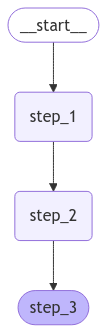

In [5]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

Let's proceed with a simple invocation:

In [6]:
graph.invoke({"value_1": "c"})

{'value_1': 'a b', 'value_2': 10}

Note that:

- We kicked off invocation by providing a value for a single state key. We must always provide a value for at least one key.
- The value we passed in was overwritten by the first node.
- The second node updated the value.
- The third node populated a different value.

!!! tip "Built-in shorthand"

    `langgraph>=0.2.46` includes a built-in short-hand `add_sequence` for adding node sequences. You can compile the same graph as follows:

    ```python
    # highlight-next-line
    builder = StateGraph(State).add_sequence([step_1, step_2, step_3])
    builder.add_edge(START, "step_1")
    
    graph = builder.compile()
    
    graph.invoke({"value_1": "c"})    
    ```

## Create branches

Parallel execution of nodes is essential to speed up overall graph operation. LangGraph offers native support for parallel execution of nodes, which can significantly enhance the performance of graph-based workflows. This parallelization is achieved through fan-out and fan-in mechanisms, utilizing both standard edges and [conditional_edges](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.MessageGraph.add_conditional_edges). Below are some examples showing how to add create branching dataflows that work for you. 

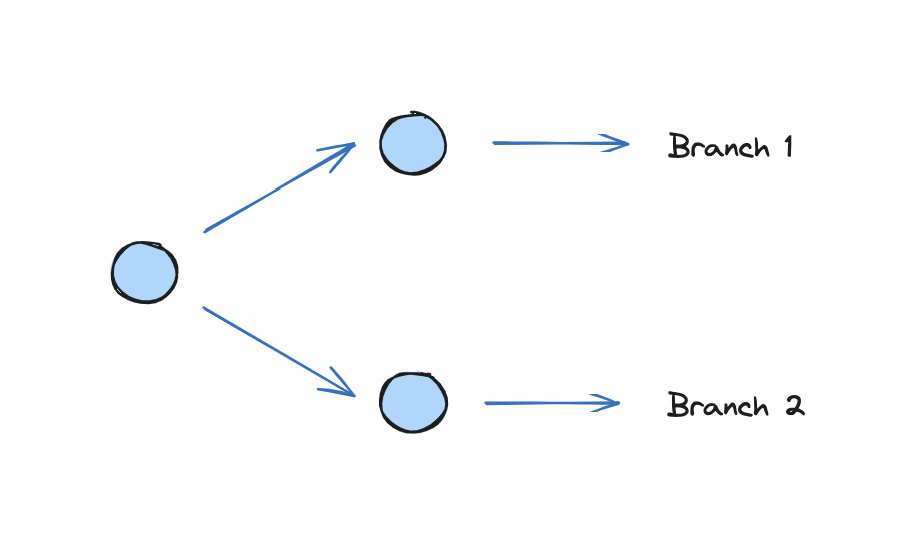

### Run graph nodes in parallel

In this example, we fan out from `Node A` to `B and C` and then fan in to `D`. With our state, [we specify the reducer add operation](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers). This will combine or accumulate values for the specific key in the State, rather than simply overwriting the existing value. For lists, this means concatenating the new list with the existing list. See the above section on [state reducers](#process-state-updates-with-reducers) for more detail on updating state with reducers.

In [1]:
import operator
from typing import Annotated, Any

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    aggregate: Annotated[list, operator.add]


def a(state: State):
    print(f'Adding "A" to {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Adding "B" to {state["aggregate"]}')
    return {"aggregate": ["B"]}


def c(state: State):
    print(f'Adding "C" to {state["aggregate"]}')
    return {"aggregate": ["C"]}


def d(state: State):
    print(f'Adding "D" to {state["aggregate"]}')
    return {"aggregate": ["D"]}


builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(c)
builder.add_node(d)
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

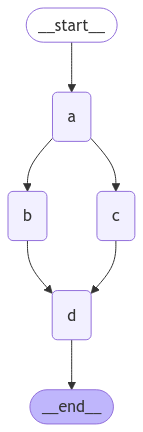

In [2]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

With the reducer, you can see that the values added in each node are accumulated.

In [8]:
graph.invoke({"aggregate": []}, {"configurable": {"thread_id": "foo"}})

Adding "A" to []
Adding "B" to ['A']
Adding "C" to ['A']
Adding "D" to ['A', 'B', 'C']


{'aggregate': ['A', 'B', 'C', 'D']}

!!! note

    In the above example, nodes `"b"` and `"c"` are executed concurrently in the same [superstep](../../concepts/low_level/#graphs). Because they are in the same step, node `"d"` executes after both `"b"` and `"c"` are finished.

    Importantly, updates from a parallel superstep may not be ordered consistently. If you need a consistent, predetermined ordering of updates from a parallel superstep, you should write the outputs to a separate field in the state together with a value with which to order them.

<details class="note"> <summary>Exception handling?</summary>
 <p>LangGraph executes nodes within <a href="https://langchain-ai.github.io/langgraph/concepts/low_level/#graphs">"supersteps"</a>, meaning that while parallel branches are executed in parallel, the entire superstep is <b>transactional</b>. If any of these branches raises an exception, <b>none</b> of the updates are applied to the state (the entire superstep errors).</p>
<p>Importantly, when using a <a href="https://langchain-ai.github.io/langgraph/concepts/persistence/">checkpointer</a>, results from successful nodes within a superstep are saved, and don't repeat when resumed.</p>
 If you have error-prone (perhaps want to handle flakey API calls), LangGraph provides two ways to address this:<br>
 <ol>
  <li>You can write regular python code within your node to catch and handle exceptions.</li>
  <li>You can set a <b><a href="https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.graph.CompiledGraph.retry_policy">retry_policy</a></b> to direct the graph to retry nodes that raise certain types of exceptions. Only failing branches are retried, so you needn't worry about performing redundant work.</li>
</ol></p>
Together, these let you perform parallel execution and fully control exception handling.
</details>

### Defer node execution

Deferring node execution is useful when you want to delay the execution of a node until all other pending tasks are completed. This is particularly relevant when branches have different lengths, which is common in workflows like map-reduce flows.

The above example showed how to fan-out and fan-in when each path was only one step. But what if one branch had more than one step? Let's add a node `"b_2"` in the `"b"` branch:

In [26]:
import operator
from typing import Annotated, Any

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    aggregate: Annotated[list, operator.add]


def a(state: State):
    print(f'Adding "A" to {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Adding "B" to {state["aggregate"]}')
    return {"aggregate": ["B"]}


def b_2(state: State):
    print(f'Adding "B_2" to {state["aggregate"]}')
    return {"aggregate": ["B_2"]}


def c(state: State):
    print(f'Adding "C" to {state["aggregate"]}')
    return {"aggregate": ["C"]}


def d(state: State):
    print(f'Adding "D" to {state["aggregate"]}')
    return {"aggregate": ["D"]}


builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(b_2)
builder.add_node(c)
# highlight-next-line
builder.add_node(d, defer=True)
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b_2")
builder.add_edge("b_2", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

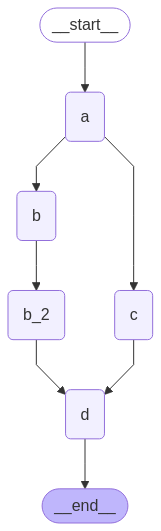

In [2]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
graph.invoke({"aggregate": []})

Adding "A" to []
Adding "B" to ['A']
Adding "C" to ['A']
Adding "B_2" to ['A', 'B', 'C']
Adding "D" to ['A', 'B', 'C', 'B_2']


{'aggregate': ['A', 'B', 'C', 'B_2', 'D']}

In the above example, nodes `"b"` and `"c"` are executed concurrently in the same superstep. We set `defer=True` on node `d` so it will not execute until all pending tasks are finished. In this case, this means that `"d"` waits to execute until the entire `"b"` branch is finished.

### Conditional branching

If your fan-out should vary at runtime based on the state, you can use [add_conditional_edges](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.StateGraph.add_conditional_edges) to select one or more paths using the graph state. See example below, where node `a` generates a state update that determines the following node.

In [11]:
import operator
from typing import Annotated, Literal, Sequence

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    aggregate: Annotated[list, operator.add]
    # Add a key to the state. We will set this key to determine
    # how we branch.
    which: str


def a(state: State):
    print(f'Adding "A" to {state["aggregate"]}')
    # highlight-next-line
    return {"aggregate": ["A"], "which": "c"}


def b(state: State):
    print(f'Adding "B" to {state["aggregate"]}')
    return {"aggregate": ["B"]}


def c(state: State):
    print(f'Adding "C" to {state["aggregate"]}')
    return {"aggregate": ["C"]}


builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(c)
builder.add_edge(START, "a")
builder.add_edge("b", END)
builder.add_edge("c", END)


def conditional_edge(state: State) -> Literal["b", "c"]:
    # Fill in arbitrary logic here that uses the state
    # to determine the next node
    return state["which"]


# highlight-next-line
builder.add_conditional_edges("a", conditional_edge)

graph = builder.compile()

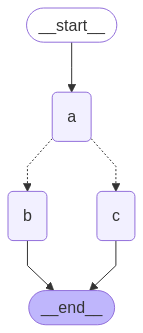

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
result = graph.invoke({"aggregate": []})
print(result)

Adding "A" to []
Adding "C" to ['A']
{'aggregate': ['A', 'C'], 'which': 'c'}


!!! tip

    Your conditional edges can route to multiple destination nodes. For example:

    ```python
    def route_bc_or_cd(state: State) -> Sequence[str]:
        if state["which"] == "cd":
            return ["c", "d"]
        return ["b", "c"]
    ```

### Map-reduce and the `Send` API

By default, `Nodes` and `Edges` are defined ahead of time and operate on the same shared state. However, there can be cases where the exact edges are not known ahead of time and/or you may want different versions of state to exist at the same time. A common example of this is with map-reduce design patterns. In this design pattern, a first node may generate a list of objects, and you may want to apply some other node to all those objects. The number of objects may be unknown ahead of time (meaning the number of edges may not be known) and the input state to the downstream `Node` should be different (one for each generated object).

To support this design pattern, LangGraph supports returning [Send](/langgraph/reference/types/#langgraph.types.Send) objects from conditional edges. `Send` takes two arguments: first is the name of the node, and second is the state to pass to that node.

```python
def continue_to_jokes(state: OverallState):
    return [Send("generate_joke", {"subject": s}) for s in state['subjects']]

graph.add_conditional_edges("node_a", continue_to_jokes)
```

Below we implement a simple example, where we simulate using LLMs to (1) generate a list of subjects (the length of which is unknown ahead of time), (2) generate jokes in parallel, and (3) select a "best" joke. Importantly, the input state to the fan-out nodes is different than the graph's overall state.

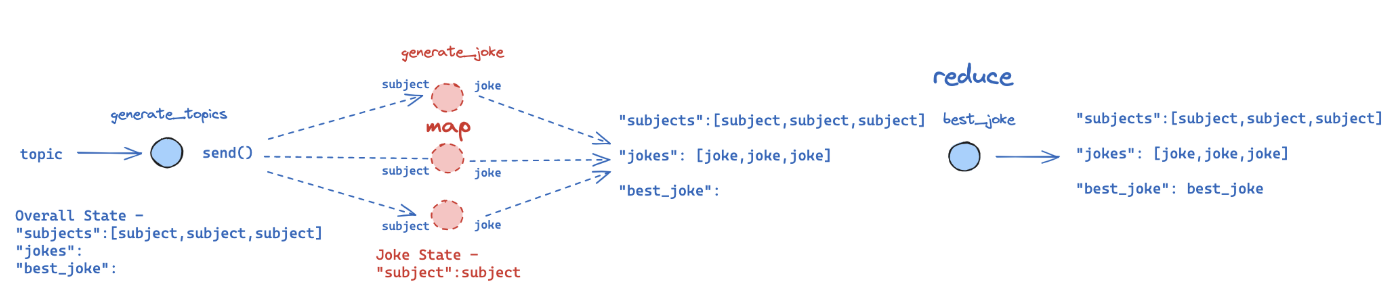

In [1]:
import operator
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.types import Send
from langgraph.graph import END, StateGraph, START


# This will be the overall state of the main graph.
# It will contain a topic (which we expect the user to provide)
# and then will generate a list of subjects, and then a joke for
# each subject
class OverallState(TypedDict):
    topic: str
    subjects: list
    # Notice here we use the operator.add
    # This is because we want combine all the jokes we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    jokes: Annotated[list, operator.add]
    best_selected_joke: str


# This will be the state of the node that we will "map" all
# subjects to in order to generate a joke
class JokeState(TypedDict):
    subject: str


# This is the function we will use to generate the subjects of the jokes.
# In general the length of the list generated by this node could vary each run.
def generate_topics(state: OverallState):
    # Simulate a LLM.
    return {"subjects": ["lions", "elephants", "penguins"]}


# Here we generate a joke, given a subject
def generate_joke(state: JokeState):
    # Simulate a LLM.
    joke_map = {
        "lions": "Why don't lions like fast food? Because they can't catch it!",
        "elephants": "Why don't elephants use computers? They're afraid of the mouse!",
        "penguins": (
            "Why don’t penguins like talking to strangers at parties? "
            "Because they find it hard to break the ice."
        ),
    }
    return {"jokes": [joke_map[state["subject"]]]}


# Here we define the logic to map out over the generated subjects
# We will use this as an edge in the graph
def continue_to_jokes(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]


# Here we will judge the best joke
def best_joke(state: OverallState):
    return {"best_selected_joke": "penguins"}


# Construct the graph: here we put everything together to construct our graph
builder = StateGraph(OverallState)
builder.add_node("generate_topics", generate_topics)
builder.add_node("generate_joke", generate_joke)
builder.add_node("best_joke", best_joke)
builder.add_edge(START, "generate_topics")
builder.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
builder.add_edge("generate_joke", "best_joke")
builder.add_edge("best_joke", END)
graph = builder.compile()

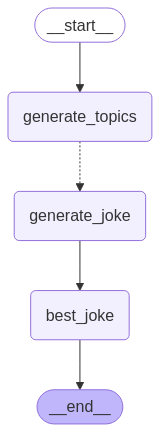

In [2]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
# Call the graph: here we call it to generate a list of jokes
for step in graph.stream({"topic": "animals"}):
    print(step)

{'generate_topics': {'subjects': ['lions', 'elephants', 'penguins']}}
{'generate_joke': {'jokes': ["Why don't lions like fast food? Because they can't catch it!"]}}
{'generate_joke': {'jokes': ["Why don't elephants use computers? They're afraid of the mouse!"]}}
{'generate_joke': {'jokes': ['Why don’t penguins like talking to strangers at parties? Because they find it hard to break the ice.']}}
{'best_joke': {'best_selected_joke': 'penguins'}}


## Create and control loops

When creating a graph with a loop, we require a mechanism for terminating execution. This is most commonly done by adding a [conditional edge](../../concepts/low_level/#conditional-edges) that routes to the [END](../../concepts/low_level/#end-node) node once we reach some termination condition.

You can also set the graph recursion limit when invoking or streaming the graph. The recursion limit sets the number of [supersteps](../../concepts/low_level/#graphs) that the graph is allowed to execute before it raises an error. Read more about the concept of recursion limits [here](../../concepts/low_level/#recursion-limit). 

Let's consider a simple graph with a loop to better understand how these mechanisms work.

!!! tip

    To return the last value of your state instead of receiving a recursion limit error, see the [next section](#impose-a-recursion-limit).

When creating a loop, you can include a conditional edge that specifies a termination condition:
```python
builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)

def route(state: State) -> Literal["b", END]:
    if termination_condition(state):
        return END
    else:
        return "b"

builder.add_edge(START, "a")
builder.add_conditional_edges("a", route)
builder.add_edge("b", "a")
graph = builder.compile()
```

To control the recursion limit, specify `"recursion_limit"` in the config. This will raise a `GraphRecursionError`, which you can catch and handle:
```python
from langgraph.errors import GraphRecursionError

try:
    graph.invoke(inputs, {"recursion_limit": 3})
except GraphRecursionError:
    print("Recursion Error")
```

Let's define a graph with a simple loop. Note that we use a conditional edge to implement a termination condition.

In [1]:
import operator
from typing import Annotated, Literal

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    aggregate: Annotated[list, operator.add]


def a(state: State):
    print(f'Node A sees {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Node B sees {state["aggregate"]}')
    return {"aggregate": ["B"]}


# Define nodes
builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)


# Define edges
def route(state: State) -> Literal["b", END]:
    if len(state["aggregate"]) < 7:
        return "b"
    else:
        return END


builder.add_edge(START, "a")
builder.add_conditional_edges("a", route)
builder.add_edge("b", "a")
graph = builder.compile()

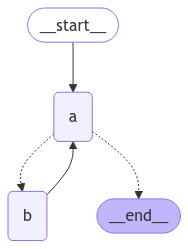

In [2]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

This architecture is similar to a [ReAct agent](../../agents/overview) in which node `"a"` is a tool-calling model, and node `"b"` represents the tools.

In our `route` conditional edge, we specify that we should end after the `"aggregate"` list in the state passes a threshold length.

Invoking the graph, we see that we alternate between nodes `"a"` and `"b"` before terminating once we reach the termination condition.

In [3]:
graph.invoke({"aggregate": []})

Node A sees []
Node B sees ['A']
Node A sees ['A', 'B']
Node B sees ['A', 'B', 'A']
Node A sees ['A', 'B', 'A', 'B']
Node B sees ['A', 'B', 'A', 'B', 'A']
Node A sees ['A', 'B', 'A', 'B', 'A', 'B']


{'aggregate': ['A', 'B', 'A', 'B', 'A', 'B', 'A']}

### Impose a recursion limit

In some applications, we may not have a guarantee that we will reach a given termination condition. In these cases, we can set the graph's [recursion limit](../../concepts/low_level/#recursion-limit). This will raise a `GraphRecursionError` after a given number of [supersteps](../../concepts/low_level/#graphs). We can then catch and handle this exception:

In [4]:
from langgraph.errors import GraphRecursionError

try:
    graph.invoke({"aggregate": []}, {"recursion_limit": 4})
except GraphRecursionError:
    print("Recursion Error")

Node A sees []
Node B sees ['A']
Node A sees ['A', 'B']
Node B sees ['A', 'B', 'A']
Recursion Error


Note that this time we terminate after the fourth step. The default recursion limit is 25.

<details class="example"><summary>Extended example: return state on hitting recursion limit</summary>

Instead of raising <code>GraphRecursionError</code>, we can introduce a new key to the state that keeps track of the number of steps remaining until reaching the recursion limit. We can then use this key to determine if we should end the run.

LangGraph implements a special <code>RemainingSteps</code> annotation. Under the hood, it creates a <code>ManagedValue</code> channel -- a state channel that will exist for the duration of our graph run and no longer.
<br>

In [1]:
import operator
from typing import Annotated, Literal

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

# highlight-next-line
from langgraph.managed.is_last_step import RemainingSteps


class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    aggregate: Annotated[list, operator.add]
    # highlight-next-line
    remaining_steps: RemainingSteps


def a(state: State):
    print(f'Node A sees {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Node B sees {state["aggregate"]}')
    return {"aggregate": ["B"]}


# Define nodes
builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)


# Define edges
def route(state: State) -> Literal["b", END]:
    # highlight-next-line
    if state["remaining_steps"] <= 2:
        return END
    else:
        return "b"


builder.add_edge(START, "a")
builder.add_conditional_edges("a", route)
builder.add_edge("b", "a")
graph = builder.compile()

# Test it out
result = graph.invoke({"aggregate": []}, {"recursion_limit": 4})
print(result)

Node A sees []
Node B sees ['A']
Node A sees ['A', 'B']
{'aggregate': ['A', 'B', 'A']}


</details>

<details class="example"><summary>Extended example: loops with branches</summary>

To better understand how the recursion limit works, let's consider a more complex example. Below we implement a loop, but one step fans out into two nodes:
<br>

In [5]:
import operator
from typing import Annotated, Literal

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    aggregate: Annotated[list, operator.add]


def a(state: State):
    print(f'Node A sees {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Node B sees {state["aggregate"]}')
    return {"aggregate": ["B"]}


def c(state: State):
    print(f'Node C sees {state["aggregate"]}')
    return {"aggregate": ["C"]}


def d(state: State):
    print(f'Node D sees {state["aggregate"]}')
    return {"aggregate": ["D"]}


# Define nodes
builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(c)
builder.add_node(d)


# Define edges
def route(state: State) -> Literal["b", END]:
    if len(state["aggregate"]) < 7:
        return "b"
    else:
        return END


builder.add_edge(START, "a")
builder.add_conditional_edges("a", route)
builder.add_edge("b", "c")
builder.add_edge("b", "d")
builder.add_edge(["c", "d"], "a")
graph = builder.compile()

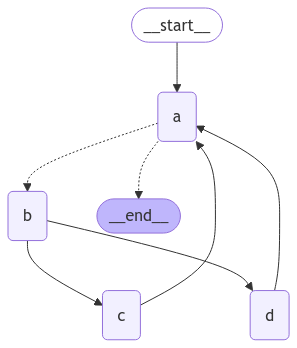

In [6]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

This graph looks complex, but can be conceptualized as loop of [supersteps](../../concepts/low_level/#graphs):

1. Node A
2. Node B
3. Nodes C and D
4. Node A
5. ...

We have a loop of four supersteps, where nodes C and D are executed concurrently.

Invoking the graph as before, we see that we complete two full "laps" before hitting the termination condition:

In [7]:
result = graph.invoke({"aggregate": []})

Node A sees []
Node B sees ['A']
Node D sees ['A', 'B']
Node C sees ['A', 'B']
Node A sees ['A', 'B', 'C', 'D']
Node B sees ['A', 'B', 'C', 'D', 'A']
Node D sees ['A', 'B', 'C', 'D', 'A', 'B']
Node C sees ['A', 'B', 'C', 'D', 'A', 'B']
Node A sees ['A', 'B', 'C', 'D', 'A', 'B', 'C', 'D']


However, if we set the recursion limit to four, we only complete one lap because each lap is four supersteps:

In [8]:
from langgraph.errors import GraphRecursionError

try:
    result = graph.invoke({"aggregate": []}, {"recursion_limit": 4})
except GraphRecursionError:
    print("Recursion Error")

Node A sees []
Node B sees ['A']
Node C sees ['A', 'B']
Node D sees ['A', 'B']
Node A sees ['A', 'B', 'C', 'D']
Recursion Error


</details>

## Async

Using the [async](https://docs.python.org/3/library/asyncio.html) programming paradigm can produce significant performance improvements when running [IO-bound](https://en.wikipedia.org/wiki/I/O_bound) code concurrently (e.g., making concurrent API requests to a chat model provider).

To convert a `sync` implementation of the graph to an `async` implementation, you will need to:

1. Update `nodes` use `async def` instead of `def`.
2. Update the code inside to use `await` appropriately.
3. Invoke the graph with `.ainvoke` or `.astream` as desired.

Because many LangChain objects implement the [Runnable Protocol](https://python.langchain.com/docs/expression_language/interface/) which has `async` variants of all the `sync` methods it's typically fairly quick to upgrade a `sync` graph to an `async` graph.

See example below. To demonstrate async invocations of underlying LLMs, we will include a chat model:

{!snippets/chat_model_tabs.md!}

```python
from langchain.chat_models import init_chat_model
from langgraph.graph import MessagesState, StateGraph


# highlight-next-line
async def node(state: MessagesState): # (1)!
    # highlight-next-line
    new_message = await llm.ainvoke(state["messages"]) # (2)!
    return {"messages": [new_message]}


builder = StateGraph(MessagesState).add_node(node).set_entry_point("node")
graph = builder.compile()

input_message = {"role": "user", "content": "Hello"}
# highlight-next-line
result = await graph.ainvoke({"messages": [input_message]}) # (3)!
```

1. Declare nodes to be async functions.
2. Use async invocations when available within the node.
3. Use async invocations on the graph object itself.

!!! tip "Async streaming"
    See the [streaming guide](../../how-tos/streaming) for examples of streaming with async.

## Combine control flow and state updates with `Command`

It can be useful to combine control flow (edges) and state updates (nodes). For example, you might want to BOTH perform state updates AND decide which node to go to next in the SAME node. LangGraph provides a way to do so by returning a [Command](/langgraph/reference/types/#langgraph.types.Command) object from node functions:

```python
def my_node(state: State) -> Command[Literal["my_other_node"]]:
    return Command(
        # state update
        update={"foo": "bar"},
        # control flow
        goto="my_other_node"
    )
```

We show an end-to-end example below. Let's create a simple graph with 3 nodes: A, B and C. We will first execute node A, and then decide whether to go to Node B or Node C next based on the output of node A.

In [2]:
import random
from typing_extensions import TypedDict, Literal

from langgraph.graph import StateGraph, START
from langgraph.types import Command


# Define graph state
class State(TypedDict):
    foo: str


# Define the nodes


def node_a(state: State) -> Command[Literal["node_b", "node_c"]]:
    print("Called A")
    value = random.choice(["a", "b"])
    # this is a replacement for a conditional edge function
    if value == "a":
        goto = "node_b"
    else:
        goto = "node_c"

    # note how Command allows you to BOTH update the graph state AND route to the next node
    return Command(
        # this is the state update
        update={"foo": value},
        # this is a replacement for an edge
        goto=goto,
    )


def node_b(state: State):
    print("Called B")
    return {"foo": state["foo"] + "b"}


def node_c(state: State):
    print("Called C")
    return {"foo": state["foo"] + "c"}

We can now create the `StateGraph` with the above nodes. Notice that the graph doesn't have [conditional edges](../../concepts/low_level#conditional-edges) for routing! This is because control flow is defined with `Command` inside `node_a`.

In [3]:
builder = StateGraph(State)
builder.add_edge(START, "node_a")
builder.add_node(node_a)
builder.add_node(node_b)
builder.add_node(node_c)
# NOTE: there are no edges between nodes A, B and C!

graph = builder.compile()

!!! important

    You might have noticed that we used `Command` as a return type annotation, e.g. `Command[Literal["node_b", "node_c"]]`. This is necessary for the graph rendering and tells LangGraph that `node_a` can navigate to `node_b` and `node_c`.

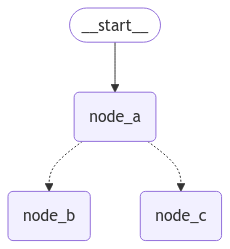

In [4]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

If we run the graph multiple times, we'd see it take different paths (A -> B or A -> C) based on the random choice in node A.

In [5]:
graph.invoke({"foo": ""})

Called A
Called C


{'foo': 'bc'}

### Navigate to a node in a parent graph

If you are using [subgraphs](../../concepts/subgraphs), you might want to navigate from a node within a subgraph to a different subgraph (i.e. a different node in the parent graph). To do so, you can specify `graph=Command.PARENT` in `Command`:

```python
def my_node(state: State) -> Command[Literal["my_other_node"]]:
    return Command(
        update={"foo": "bar"},
        goto="other_subgraph",  # where `other_subgraph` is a node in the parent graph
        graph=Command.PARENT
    )
```

Let's demonstrate this using the above example. We'll do so by changing `node_a` in the above example into a single-node graph that we'll add as a subgraph to our parent graph.

!!! important "State updates with `Command.PARENT`"

    When you send updates from a subgraph node to a parent graph node for a key that's shared by both parent and subgraph [state schemas](../../concepts/low_level#schema), you **must** define a [reducer](../../concepts/low_level#reducers) for the key you're updating in the parent graph state. See the example below.

In [6]:
import operator
from typing_extensions import Annotated


class State(TypedDict):
    # NOTE: we define a reducer here
    # highlight-next-line
    foo: Annotated[str, operator.add]


def node_a(state: State):
    print("Called A")
    value = random.choice(["a", "b"])
    # this is a replacement for a conditional edge function
    if value == "a":
        goto = "node_b"
    else:
        goto = "node_c"

    # note how Command allows you to BOTH update the graph state AND route to the next node
    return Command(
        update={"foo": value},
        goto=goto,
        # this tells LangGraph to navigate to node_b or node_c in the parent graph
        # NOTE: this will navigate to the closest parent graph relative to the subgraph
        # highlight-next-line
        graph=Command.PARENT,
    )


subgraph = StateGraph(State).add_node(node_a).add_edge(START, "node_a").compile()


def node_b(state: State):
    print("Called B")
    # NOTE: since we've defined a reducer, we don't need to manually append
    # new characters to existing 'foo' value. instead, reducer will append these
    # automatically (via operator.add)
    # highlight-next-line
    return {"foo": "b"}


def node_c(state: State):
    print("Called C")
    # highlight-next-line
    return {"foo": "c"}

In [7]:
builder = StateGraph(State)
builder.add_edge(START, "subgraph")
builder.add_node("subgraph", subgraph)
builder.add_node(node_b)
builder.add_node(node_c)

graph = builder.compile()

In [8]:
graph.invoke({"foo": ""})

Called A
Called C


{'foo': 'bc'}

### Use inside tools

A common use case is updating graph state from inside a tool. For example, in a customer support application you might want to look up customer information based on their account number or ID in the beginning of the conversation. To update the graph state from the tool, you can return `Command(update={"my_custom_key": "foo", "messages": [...]})` from the tool:

```python
@tool
def lookup_user_info(tool_call_id: Annotated[str, InjectedToolCallId], config: RunnableConfig):
    """Use this to look up user information to better assist them with their questions."""
    user_info = get_user_info(config.get("configurable", {}).get("user_id"))
    return Command(
        update={
            # update the state keys
            "user_info": user_info,
            # update the message history
            "messages": [ToolMessage("Successfully looked up user information", tool_call_id=tool_call_id)]
        }
    )
```

!!! important
    You MUST include `messages` (or any state key used for the message history) in `Command.update` when returning `Command` from a tool and the list of messages in `messages` MUST contain a `ToolMessage`. This is necessary for the resulting message history to be valid (LLM providers require AI messages with tool calls to be followed by the tool result messages).

If you are using tools that update state via `Command`, we recommend using prebuilt [`ToolNode`][langgraph.prebuilt.tool_node.ToolNode] which automatically handles tools returning `Command` objects and propagates them to the graph state. If you're writing a custom node that calls tools, you would need to manually propagate `Command` objects returned by the tools as the update from the node.

## Visualize your graph

Here we demonstrate how to visualize the graphs you create.

You can visualize any arbitrary [Graph](https://langchain-ai.github.io/langgraph/reference/graphs/), including [StateGraph](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.state.StateGraph). Let's have some fun by drawing fractals :).

In [1]:
import random
from typing import Annotated, Literal

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


class MyNode:
    def __init__(self, name: str):
        self.name = name

    def __call__(self, state: State):
        return {"messages": [("assistant", f"Called node {self.name}")]}


def route(state) -> Literal["entry_node", "__end__"]:
    if len(state["messages"]) > 10:
        return "__end__"
    return "entry_node"


def add_fractal_nodes(builder, current_node, level, max_level):
    if level > max_level:
        return

    # Number of nodes to create at this level
    num_nodes = random.randint(1, 3)  # Adjust randomness as needed
    for i in range(num_nodes):
        nm = ["A", "B", "C"][i]
        node_name = f"node_{current_node}_{nm}"
        builder.add_node(node_name, MyNode(node_name))
        builder.add_edge(current_node, node_name)

        # Recursively add more nodes
        r = random.random()
        if r > 0.2 and level + 1 < max_level:
            add_fractal_nodes(builder, node_name, level + 1, max_level)
        elif r > 0.05:
            builder.add_conditional_edges(node_name, route, node_name)
        else:
            # End
            builder.add_edge(node_name, "__end__")


def build_fractal_graph(max_level: int):
    builder = StateGraph(State)
    entry_point = "entry_node"
    builder.add_node(entry_point, MyNode(entry_point))
    builder.add_edge(START, entry_point)

    add_fractal_nodes(builder, entry_point, 1, max_level)

    # Optional: set a finish point if required
    builder.add_edge(entry_point, END)  # or any specific node

    return builder.compile()


app = build_fractal_graph(3)

### Mermaid

We can also convert a graph class into Mermaid syntax.

In [3]:
print(app.get_graph().draw_mermaid())

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([<p>__start__</p>]):::first
	entry_node(entry_node)
	node_entry_node_A(node_entry_node_A)
	node_entry_node_B(node_entry_node_B)
	node_node_entry_node_B_A(node_node_entry_node_B_A)
	node_node_entry_node_B_B(node_node_entry_node_B_B)
	node_node_entry_node_B_C(node_node_entry_node_B_C)
	__end__([<p>__end__</p>]):::last
	__start__ --> entry_node;
	entry_node --> __end__;
	entry_node --> node_entry_node_A;
	entry_node --> node_entry_node_B;
	node_entry_node_B --> node_node_entry_node_B_A;
	node_entry_node_B --> node_node_entry_node_B_B;
	node_entry_node_B --> node_node_entry_node_B_C;
	node_entry_node_A -.-> entry_node;
	node_entry_node_A -.-> __end__;
	node_node_entry_node_B_A -.-> entry_node;
	node_node_entry_node_B_A -.-> __end__;
	node_node_entry_node_B_B -.-> entry_node;
	node_node_entry_node_B_B -.-> __end__;
	node_node_entry_node_B_C -.-> entry_node;
	node_node_entry_node_B_C -.-> __end__;
	classDef default fill:#f2f

### PNG

If preferred, we could render the Graph into a  `.png`. Here we could use three options:

- Using Mermaid.ink API (does not require additional packages)
- Using Mermaid + Pyppeteer (requires `pip install pyppeteer`)
- Using graphviz (which requires `pip install graphviz`)


**Using Mermaid.Ink**

By default, `draw_mermaid_png()` uses Mermaid.Ink's API to generate the diagram.

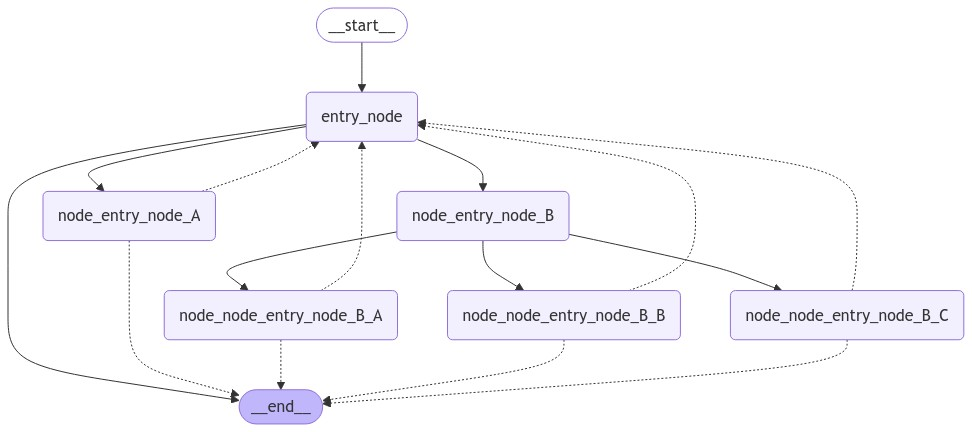

In [4]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(Image(app.get_graph().draw_mermaid_png()))

**Using Mermaid + Pyppeteer**

In [ ]:
%%capture --no-stderr
%pip install --quiet pyppeteer
%pip install --quiet nest_asyncio

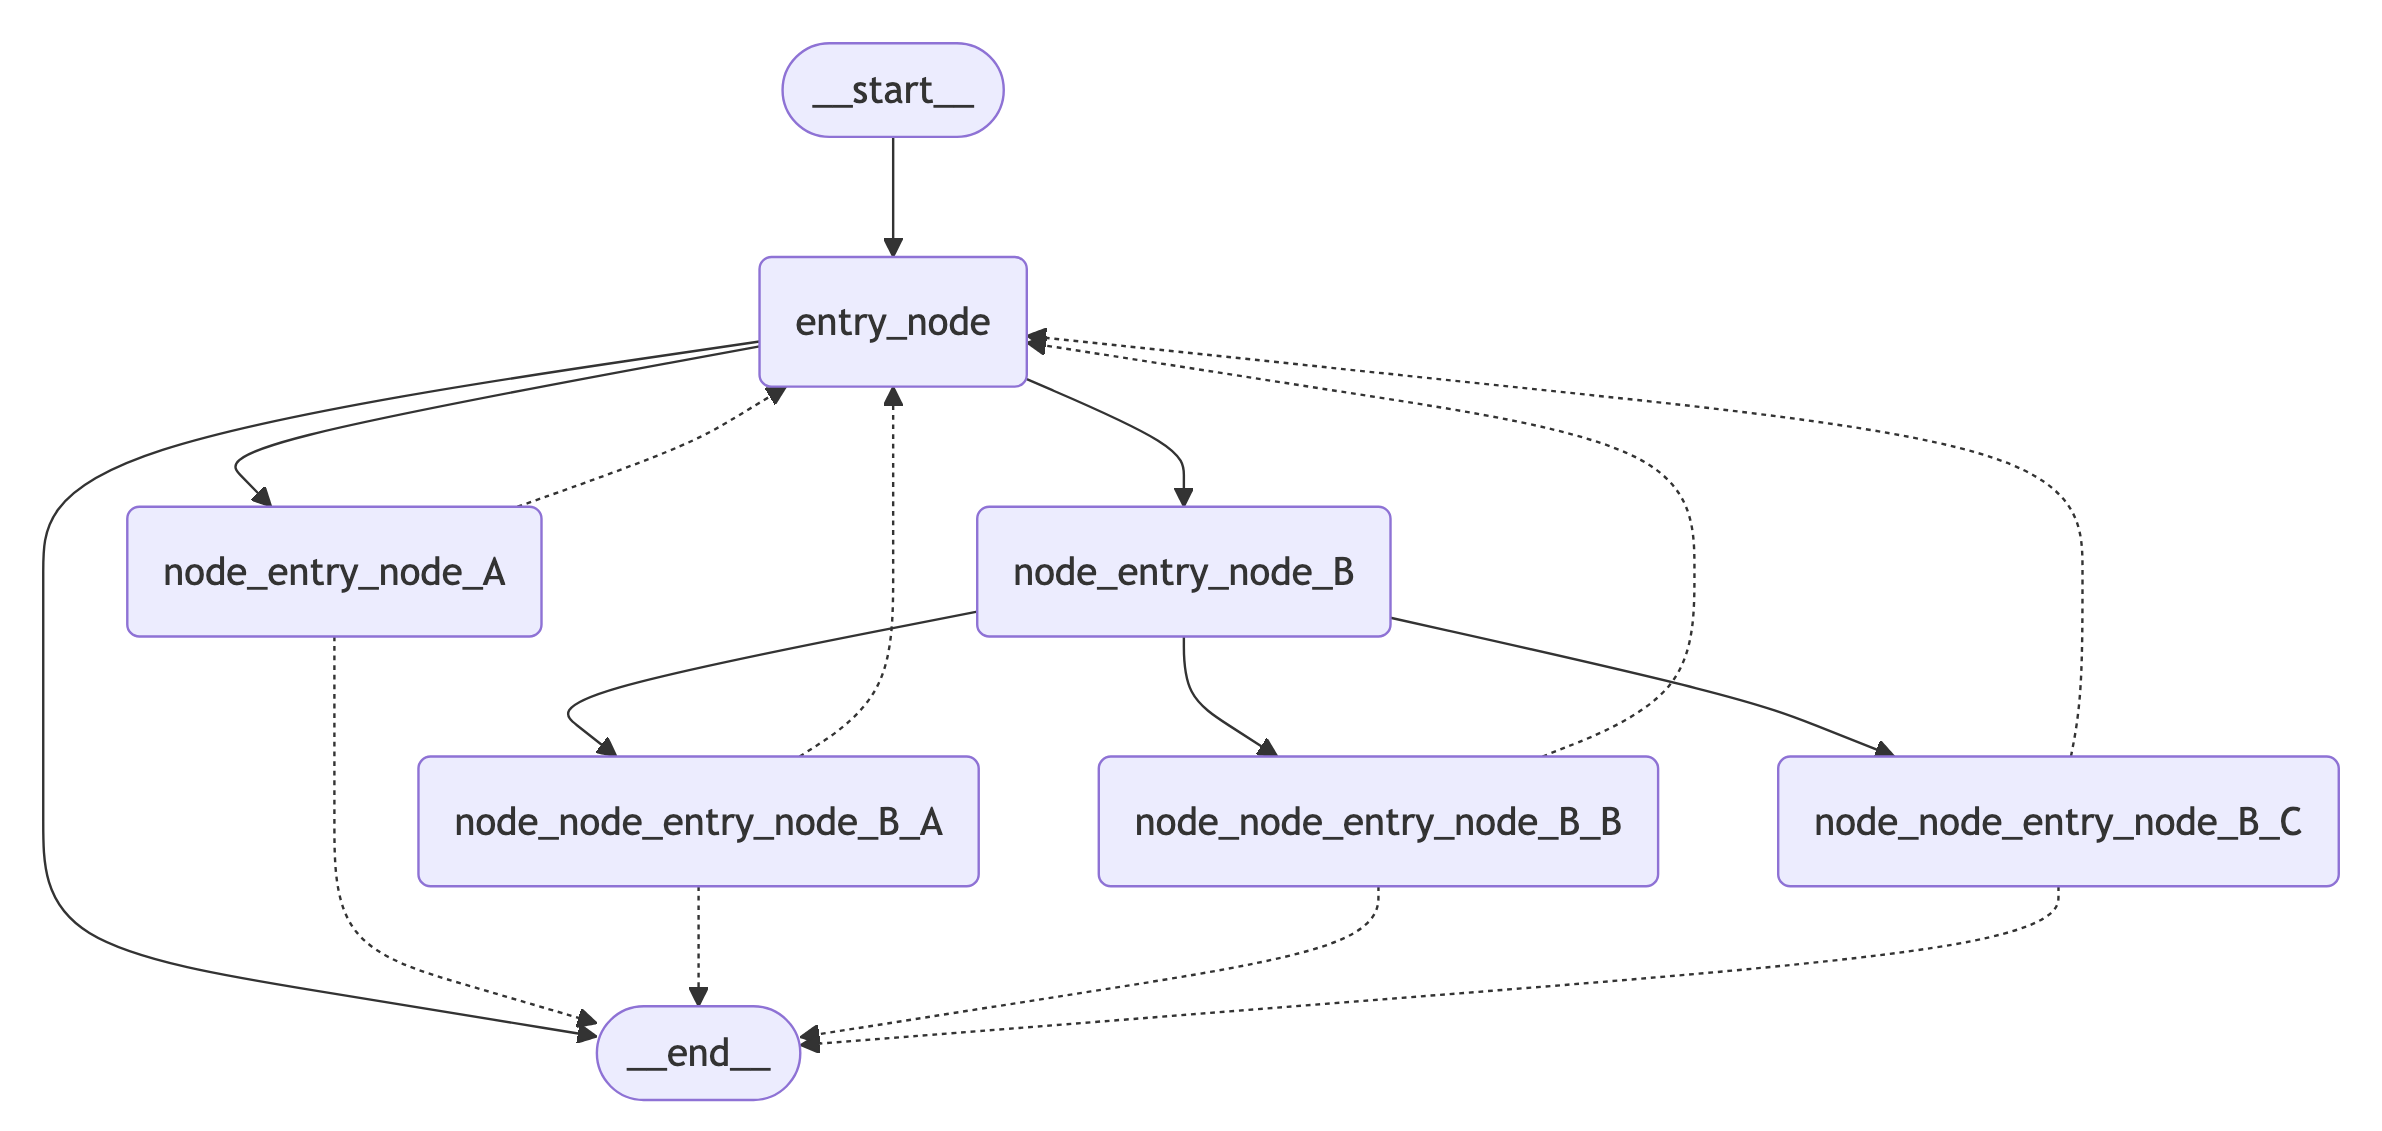

In [5]:
import nest_asyncio

nest_asyncio.apply()  # Required for Jupyter Notebook to run async functions

display(
    Image(
        app.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.PYPPETEER,
            background_color="white",
            padding=10,
        )
    )
)

**Using Graphviz**

In [ ]:
%%capture --no-stderr
%pip install pygraphviz

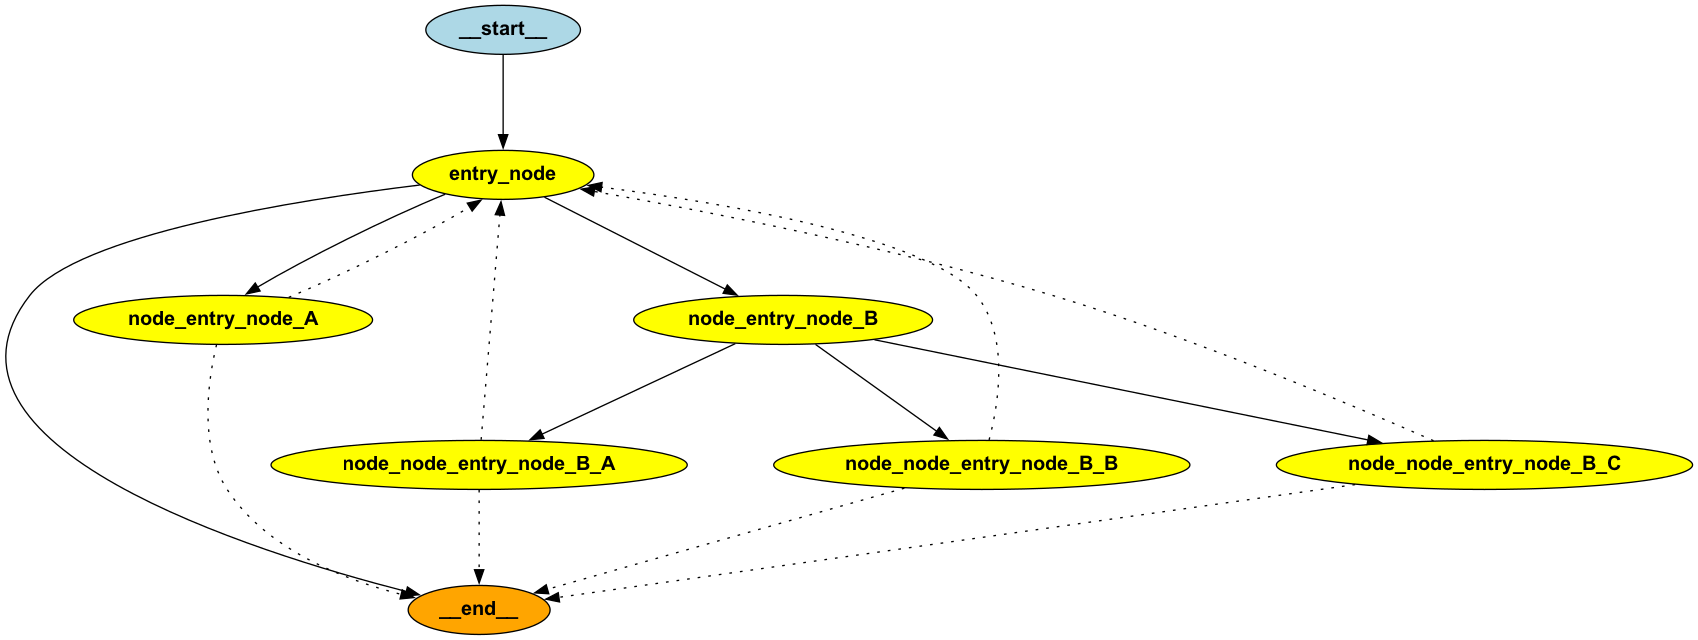

In [6]:
try:
    display(Image(app.get_graph().draw_png()))
except ImportError:
    print(
        "You likely need to install dependencies for pygraphviz, see more here https://github.com/pygraphviz/pygraphviz/blob/main/INSTALL.txt"
    )